## Example: Preparing a data catalog

This example illustrates the how to prepare your own HydroMT [DataCatalog](https://deltares.github.io/hydromt/latest/_generated/hydromt.data_catalog.DataCatalog.html) to reference your own data sources and start using then within HydroMT.

In [1]:
# import hydromt and setup logging
import os
from pprint import pprint
import hydromt
from hydromt.log import setuplog

logger = setuplog("prepare data catalog", log_level=10)

2022-10-26 18:08:35,503 - prepare data catalog - log - INFO - HydroMT version: 0.6.1.dev


The steps to use your own data within HydroMT are in brief:

  1) **Have your (local) dataset ready** in one of the supported [raster](https://deltares.github.io/hydromt/latest/user_guide/data_types.html#raster-formats) (tif, ascii, netcdf, zarr...), 
   [vector](https://deltares.github.io/hydromt/latest/user_guide/data_types.html#vector-formats) (shp, geojson, gpkg...) or [geospatial time-series](https://deltares.github.io/hydromt/latest/user_guide/data_types.html#geo-formats) (netcdf, csv...) format.
  2) **Create your own [yaml file](https://deltares.github.io/hydromt/latest/user_guide/data_prepare_cat.html#data-yaml)** with a reference to your prepared dataset and properties (path, data_type, driver, etc.) following the HydroMT [data conventions](https://deltares.github.io/hydromt/latest/user_guide/data_conventions.html#data-convention). For this step, you can also start from an existing pre-defined catalog or use it for inspiration.

The existing pre-defined catalog are:

In [2]:
data_catalog = hydromt.DataCatalog()
pprint(data_catalog.predefined_catalogs)

{'artifact_data': {'notes': 'This data archive contains a sample dataset for '
                            'the Piave basin (North Italy) to be used for '
                            'tests and docs/demo purposes.',
                   'urlpath': 'https://github.com/DirkEilander/hydromt-artifacts/releases/download/{version}/data.tar.gz',
                   'versions': {'v0.0.6': 'v0.0.6'}},
 'deltares_data': {'notes': 'This data is only accessible when connected to '
                            'the Deltares network.',
                   'urlpath': 'https://raw.githubusercontent.com/Deltares/hydromt/{version}/data/catalogs/deltares_data.yml',
                   'versions': {'v2022.5': 'd88cc47bd4ecc83de38c00aa554a7d48ad23ec23',
                                'v2022.7': 'main'}}}


In this notebook, we will see how we can create a data catalog for several type of input data. For this we have prepared several type of data that we will catalogue, let's see which data we have available:

In [23]:
folder_name = 'data'
for path, _, files in os.walk(folder_name):
    print(path)
    for name in files:
        if name.endswith(".xml"):
            continue
        print(f" - {name}")

data
 - climate.nc
 - gtsmv3_eu_era5.nc
 - rivers_lin2019.gpkg
 - vito.tif
data\merit_hydro_1k
 - dir.tif
 - elv.tif


### RasterDataset from raster file

The first file we will use is a 'simple' raster file in a tif format: **vito.tif**. This file contains a landuse classification raster. The first thing to do before adding a new file to a data catalog is to get to know what is inside of our file mainly:

  - **location of the file**: `path`.
  - **type of data**: `data_type`. `RasterDataset` for gridded data, `GeoDataFrame` for vector data, `GeoDataset` for point timeseries and `DataFrame` for tabular data.
  - **file format**: `driver`. The file format impacts the driver or python function that will be used to open the data. Either `raster`, `raster_tindex`, `netcdf`, `zarr`, `vector`, `vector_table`.
  - **crs**: `crs`. Coordinate sytem of the data. Optional as it is usually encoded in the data itself.
  - **variables and their properties**: `rename`, `unit_mult`, `unit_add`. Looking at the variables in the input data and what are their names and units so that we can convert them to the [HydroMT data conventions](https://deltares.github.io/hydromt/latest/user_guide/data_conventions.html).
  
There are more arguments or properties to look for that are explained in more detailed in the [documentation](https://deltares.github.io/hydromt/latest/user_guide/data_prepare_cat.html). To discover our data we can either use GIS software like QGIS or GDAL or just use python directly to try and open the data.

Let's open our vito.tif file with xarray and rioxarray:

<xarray.DataArray 'band_data' (band: 1, y: 1613, x: 1412)>
[2277556 values with dtype=float32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 11.6 11.6 11.6 11.6 11.6 ... 13.0 13.0 13.0 13.0
  * y            (y) float64 46.8 46.8 46.8 46.8 46.8 ... 45.2 45.2 45.2 45.2
    spatial_ref  int32 ...
Attributes:
    AREA_OR_POINT:  Area
CRS: EPSG:4326


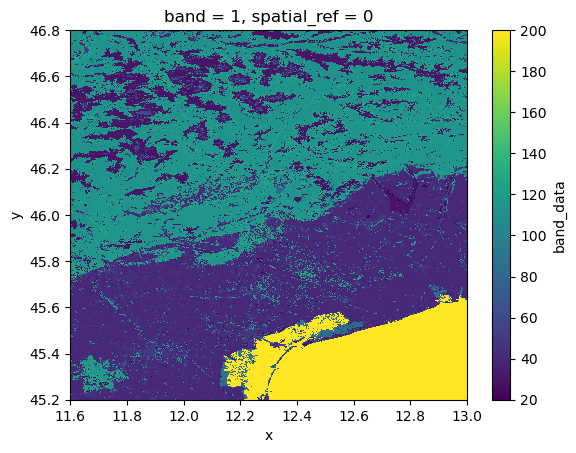

In [27]:
import xarray as xr
import rioxarray

da = xr.open_dataarray('data/vito.tif')
pprint(da)
print(f'CRS: {da.raster.crs}')
da.plot()

What we see is that we have a simple raster with landuse data in crs 4326. Let's translate what we know into a data catalog.

The `%%writefile` magic saves the content below to a file. The content of the yaml file start from the second line.

In [28]:
%%writefile ./tmp_data_catalog.yml
vito:
    path: 'data/vito.tif'
    data_type: RasterDataset
    driver: raster
    crs: 4326
    meta:
        category: landuse

Writing ./tmp_data_catalog.yml


And let's now see if HydroMT can properly read the file from the data catalog we prepared:

In [30]:
data_catalog = hydromt.DataCatalog('tmp_data_catalog.yml', logger=logger)
da = data_catalog.get_rasterdataset('vito')
da

2022-10-26 18:41:06,729 - prepare data catalog - data_catalog - INFO - Parsing data catalog from tmp_data_catalog.yml
2022-10-26 18:41:06,736 - prepare data catalog - data_catalog - INFO - DataCatalog: Getting vito RasterDataset raster data from C:\Users\boisgont\D\Repos\hydromt\hydromt\examples\data\vito.tif


<xarray.DataArray 'vito' (y: 1613, x: 1412)>
dask.array<getitem, shape=(1613, 1412), dtype=uint8, chunksize=(1613, 1412), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 11.6 11.6 11.6 11.6 11.6 ... 13.0 13.0 13.0 13.0
  * y            (y) float64 46.8 46.8 46.8 46.8 46.8 ... 45.2 45.2 45.2 45.2
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     255
    source_file:    vito.tif
    category:       landuse

### RasterDataset from several raster files

merit_hydro: rename vars + {variable} placeholder

### RasterDataset from a netcdf file

climate.nc: rename vars + unit_mult unit_add

### GeoDataFrame from a vector file

rivers_lin: rename vars

### GeoDataset from a netcdf file

gtsm: just open

### GeoDataset from vector files

stations.csv and stations_data.csv - use the reading point timeseries example: just open